# Trader ROI analysis notebook

## How to run this notebook
1. Clone locally trader quickstart repository https://github.com/valory-xyz/trader-quickstart (branch main)
2. Clone locally market creator repository https://github.com/valory-xyz/market-creator (branch feat/roi_analysis). The rest of the steps occur on the market creator repository.
3. Poetry install
    ```bash
    cd market-creator
    poetry shell
    poetry install
    ```

4. Copy the file sample.env to .env

    ```bash
    cd notebooks
    cp sample.env .env
    ```

5. Populate the variables inside the .env file. The variable `GNOSISSCAN_API_KEY` is only required for the last part of the notebook. Fill to a dummy value if you don’t want to use it.

    ```bash
    RPC=
    SUBGRAPH_API_KEY=
    GNOSISSCAN_API_KEY=
    TRADER_QUICKSTART_PATH=
    ```

6. The first time you want to run an analysis for a service, it’s recommended that you create the dataset outside the notebook as follows:
    
    ```bash
    python generate_roi_analysis_dataset.py 327
    ```

    If you are collecting a lot of data, it might take a while to generate the dataset, and you might need to run the scripts multiple times, due to network errors.
    As a result of this step you should end with a file called `roi_analysis_dataset_<service_id>.json`

7. Edit the cell of this notebook with the required data

    ```python
    # Edit these parameters accordingly
    service_id = 335
    start_date_str = "2024-03-01T00:00:01Z"
    end_date_str = "2024-09-16T23:59:59Z"
    ```

8. Run the notebook.

Notes:

- The dataset collection process collects the whole data for a service.
- The notebook will then filter for the specified date range and closed markets.
- Therefore, re-running the notebook will only update the trades/mech calls made since last running (should be a <1 minute process if less than 100 new trades or mech calls). 
- For quickly usage, if you don’t want to re-collect data, simply comment the following line on the notebook:

    ```python
    generate_dataset(service_id)
    ```

In [10]:
import ipywidgets as widgets
import json
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import requests
import pandas as pd
import pytz
from collections import defaultdict, Counter
from datetime import datetime, timedelta, timezone
from dotenv import dotenv_values
from IPython.display import display, HTML

DOTENV_PATH = ".env"

env_file_vars = dotenv_values(DOTENV_PATH)
trader_quickstart_path = env_file_vars.get("TRADER_QUICKSTART_PATH")

sys.path.insert(0, '../scripts')
sys.path.insert(0, os.path.expanduser(trader_quickstart_path))
sys.path.insert(0, os.path.expanduser(f"{trader_quickstart_path}/scripts"))

from generate_roi_analysis_dataset import get_service_safe, generate_dataset, DATASET_PREFIX
from trades import MarketState, TradeResult, INVALID_ANSWER, _compute_roi

def annotate_bars(ax):
    """Annotates each bar in the given axis with its height value."""
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')

In [11]:
# Edit these parameters accordingly
service_id = 335
start_date_str = "2024-03-01T00:00:01Z"
end_date_str = "2024-09-16T23:59:59Z"

In [12]:
service_safe_address = get_service_safe(service_id)

print(f"{service_id=}")
print(f"{service_safe_address=}")

dataset_json = f"{DATASET_PREFIX}{service_id}.json"

# Comment this line to avoid updating the dataset
generate_dataset(service_id)

with open(dataset_json, 'r') as file:
    data = json.load(file)
    mech_requests = data["mechRequests"]
    fpmm_trades = data["fpmmTrades"]
    outstanding_mech_request_ids = data["outstandingMechRequestIds"]

service_id=335
service_safe_address='0x3c01B79BaD670A37C8784bDf47b973b341064f10'
service_id=335
service_safe_address='0x3c01B79BaD670A37C8784bDf47b973b341064f10'
0x3c01b79bad670a37c8784bdf47b973b341064f10
          Fetching requests...
          16569 requests found


    Finding duplicate delivers: 100%|██████████| 16569/16569 [00:00<00:00, 116791.96it/s]


Duplicate deliver ids found: 0


 Processing duplicate delivers: 0it [00:00, ?it/s]
    Finding duplicate delivers: 100%|██████████| 16569/16569 [00:00<00:00, 677019.97it/s]


Duplicate deliver ids found: 0


        Fetching IPFS contents: 0it [00:00, ?it/s]


Time of execution: 0:00:29.735739
Populating mech requests...
Populating market states...
Finished generating datasets for service 335

Finished reading dataset:
  - 2775 trades
  - 16569 mech requests
  - 13794 outstanding mech requests


In [13]:
# Transform to a Dataframe

df = pd.json_normalize(fpmm_trades)

df['creationTimestamp'] = pd.to_numeric(df['creationTimestamp'], errors='coerce')

df['result'] = df['result'].map(TradeResult)
df['result'] = pd.Categorical(df['result'])

df['fpmm.state'] = df['fpmm.state'].map(lambda x: MarketState(x).name.lower())
df['fpmm.state'] = pd.Categorical(df['fpmm.state'])

df['mechTool'] = df['mechRequestId'].map(lambda x: mech_requests[x]['ipfsContents']['tool'])

df['deliver.confidence'] = df['mechRequestId'].map(lambda x: json.loads(mech_requests[x]['deliver']['ipfsContents']['result'])['confidence'])
df['deliver.p_yes'] = df['mechRequestId'].map(lambda x: json.loads(mech_requests[x]['deliver']['ipfsContents']['result'])['p_yes'])

df['collateralAmount'] = df['collateralAmount'].astype(float) / 1e18
df['outcomeTokensTraded'] = df['outcomeTokensTraded'].astype(float) / 1e18
df['feeAmount'] = df['feeAmount'].astype(float) / 1e18

# Display a few columns and rows
df_selected = df[['id', 'outcomeTokensTraded', 'fpmm.state', 'result', 'mechTool', 'deliver.confidence', 'deliver.p_yes']]
display(HTML(df_selected.head(5).to_html(index=False)))
print(df.columns)


id,outcomeTokensTraded,fpmm.state,result,mechTool,deliver.confidence,deliver.p_yes
0x47feda1a124caec341d8f60e5d524c77a76545a10x3c01b79bad670a37c8784bdf47b973b341064f100x1,0.286803,closed,Win,prediction-online-sme,0.8,0.15
0x02b29b4025d4bc4a93a24304a5bebaa930cd53e10x3c01b79bad670a37c8784bdf47b973b341064f100x2,0.203868,closed,Win,prediction-online-sme,0.8,0.30
0x703667dcd2860823fdcdabe4ed0b337efc17ab100x3c01b79bad670a37c8784bdf47b973b341064f100x3,0.214452,closed,Win,prediction-online-sme,0.8,0.30
0x703667dcd2860823fdcdabe4ed0b337efc17ab100x3c01b79bad670a37c8784bdf47b973b341064f100x5d,0.226488,closed,Win,prediction-online-sme,0.8,0.30
0x9a2e0a075256fd2f21dfe8bbf1af7fdcd45b70f10x3c01b79bad670a37c8784bdf47b973b341064f100x4,0.213473,closed,Win,prediction-online-sme,0.8,0.30


Index(['collateralAmount', 'collateralAmountUSD', 'collateralToken',
       'creationTimestamp', 'feeAmount', 'id', 'mechRequestId',
       'oldOutcomeTokenMarginalPrice', 'outcomeIndex',
       'outcomeTokenMarginalPrice', 'outcomeTokensTraded', 'result', 'title',
       'transactionHash', 'type', 'creator.id',
       'fpmm.answerFinalizedTimestamp', 'fpmm.arbitrationOccurred',
       'fpmm.condition.id', 'fpmm.currentAnswer', 'fpmm.id',
       'fpmm.isPendingArbitration', 'fpmm.openingTimestamp', 'fpmm.outcomes',
       'fpmm.state', 'fpmm.title', 'mechTool', 'deliver.confidence',
       'deliver.p_yes'],
      dtype='object')


In [14]:
# Filter dataset

start_timestamp = datetime.fromisoformat(start_date_str.replace("Z", "+00:00")).timestamp()
end_timestamp = datetime.fromisoformat(end_date_str.replace("Z", "+00:00")).timestamp()

print(f"Total trades: {len(df)}")

# Filter by selected dates
df = df[(df['creationTimestamp'] >= start_timestamp) & (df['creationTimestamp'] <= end_timestamp)]
print(f"Start date: {start_date_str}")
print(f"End date: {end_date_str}")
print(f"Filtered by date: {len(df)}")

# Filter by closed state
df = df[df['fpmm.state'] == 'closed']
print(f"Filtered by state: {len(df)}")
print("")

# Filter outstanding mech requests
print(f"Total outstanding mech requests: {len(outstanding_mech_request_ids)}")

outstanding_mech_request_ids = [request_id for request_id in outstanding_mech_request_ids 
                          if start_timestamp <= int(mech_requests[request_id]['blockTimestamp']) <= end_timestamp]
print(f"Filtered by date: {len(outstanding_mech_request_ids)}")

print("")
print(f"Summary of period {start_date_str} - {end_date_str}")
print("-------------------------------------------------------------")

investment = df['collateralAmount'].sum()
market_fees = df['feeAmount'].sum()
mech_fees = 0.01 * len(df)
outstanding_mech_fees = 0.01 * len(outstanding_mech_request_ids)
win_earnings = df[df['result'] == TradeResult.WIN]['outcomeTokensTraded'].sum()
invalid_earnings = df[df['result'] == TradeResult.INVALID]['collateralAmount'].sum()

roi = _compute_roi(
    investment + market_fees + mech_fees + outstanding_mech_fees,
    win_earnings + invalid_earnings
)

print(f"Total trades:     {len(df)}")

print("counts:")
result_counts = df['result'].value_counts()
print(result_counts)
print("")


# Sum the 'outcomeTokensTraded' per result type
print("collateralAmount:")
outcome_sums = df.groupby('result', observed=False)['collateralAmount'].sum()
print(outcome_sums)



print(f"{investment= }")
print(f"{market_fees= }")
print(f"{mech_fees= }")
print(f"{outstanding_mech_fees= }")
print(f"{win_earnings= }")
print(f"{invalid_earnings= }")
print("")
print(f"{roi=}")


Total trades: 2775
Start date: 2024-03-01T00:00:01Z
End date: 2024-09-16T23:59:59Z
Filtered by date: 2775
Filtered by state: 2721

Total outstanding mech requests: 13794
Filtered by date: 13794

Summary of period 2024-03-01T00:00:01Z - 2024-09-16T23:59:59Z
-------------------------------------------------------------
Total trades:     2721
counts:
result
Win        1370
Lose       1030
Invalid     321
Unknown       0
Name: count, dtype: int64

collateralAmount:
result
Win        669.925229
Lose       420.143946
Invalid    115.394206
Unknown      0.000000
Name: collateralAmount, dtype: float64
investment= 1205.4633803753843
market_fees= 24.109267607507682
mech_fees= 27.21
outstanding_mech_fees= 137.94
win_earnings= 1118.4334728628808
invalid_earnings= 115.39420550288135

roi=-0.1153598314688754


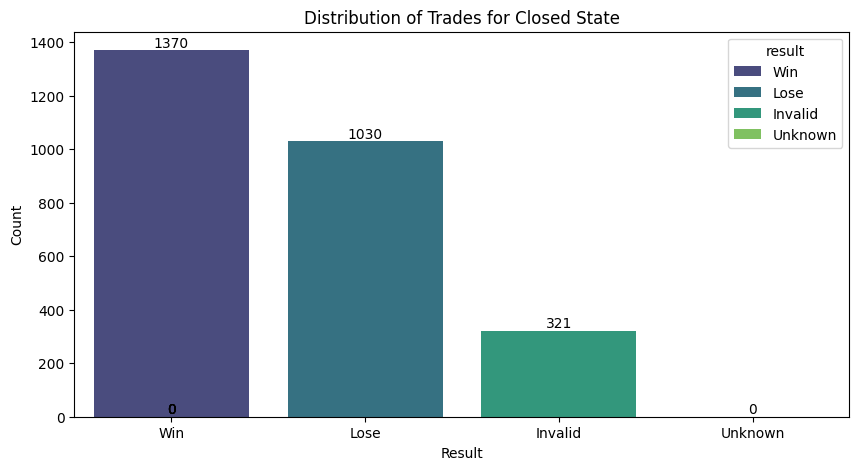

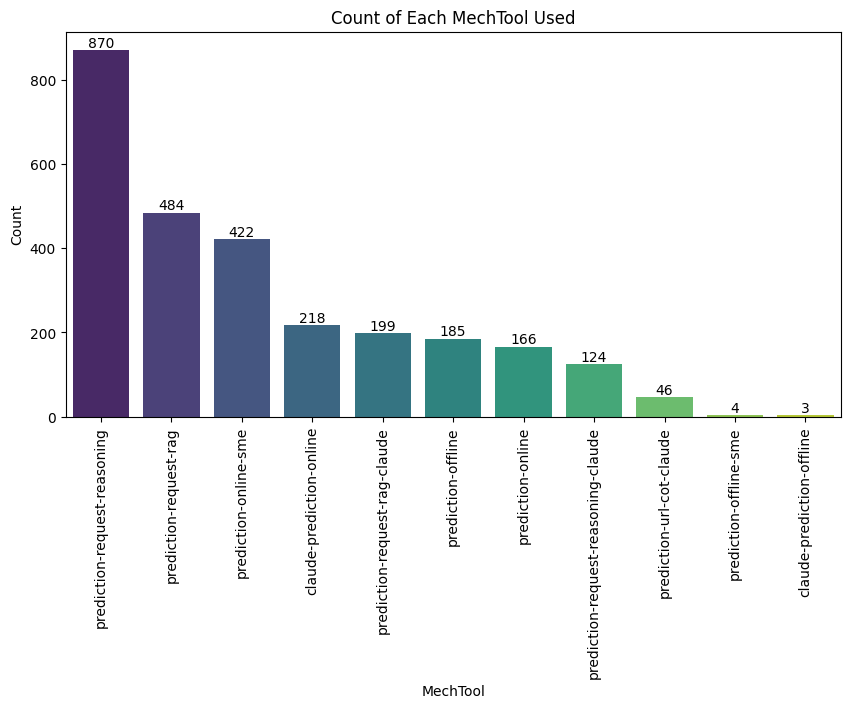

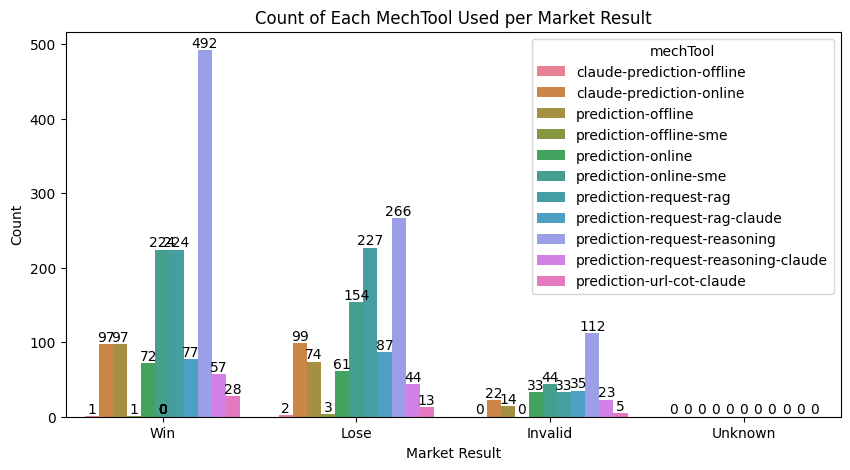

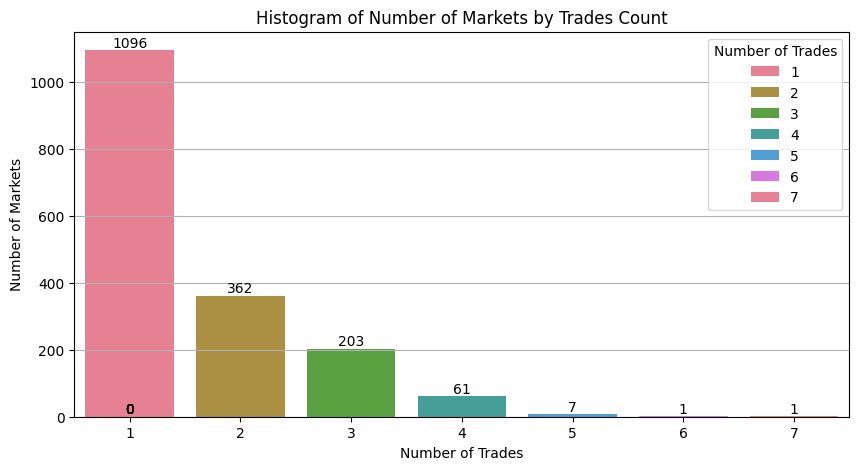

Market with the highest number of trades: 0xd86896e9c34582737dc6c910ada3b6df0a5f8301 (7 trades)


In [15]:
# Display count by state
result_counts = df['result'].value_counts()
#print(result_counts)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=result_counts.index, y=result_counts.values, palette='viridis', hue=result_counts.index)
annotate_bars(ax)
plt.title("Distribution of Trades for Closed State")
plt.xlabel("Result")
plt.ylabel("Count")
plt.show()

# Count occurrences of each mech_tool
mech_tool_counts = df['mechTool'].value_counts()
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=mech_tool_counts.index, y=mech_tool_counts.values, palette='viridis', hue=mech_tool_counts.index)
annotate_bars(ax)
plt.title("Count of Each MechTool Used")
plt.xlabel("MechTool")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

# Count occurrences of each mech_tool per result
mech_tool_counts = df.groupby(['result', 'mechTool'], observed=False).size().reset_index(name='count')
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='result', y='count', hue='mechTool', data=mech_tool_counts, palette='husl')
annotate_bars(ax)
plt.title("Count of Each MechTool Used per Market Result")
plt.xlabel("Market Result")
plt.ylabel("Count")
plt.show()

# Count the number of trades per market
trades_per_market = df.groupby('fpmm.id').size()
market_counts = trades_per_market.value_counts().sort_index().reset_index()
market_counts.columns = ['Number of Trades', 'Number of Markets']
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Number of Trades', y='Number of Markets', data=market_counts, palette='husl', hue='Number of Trades')
annotate_bars(ax)
plt.title('Histogram of Number of Markets by Trades Count')
plt.xlabel('Number of Trades')
plt.ylabel('Number of Markets')
plt.grid(axis='y')
plt.show()


# Find the market with the maximum number of trades
max_trades_market = trades_per_market.idxmax()  # Get the fpmm_id with the highest count
max_trades_count = trades_per_market.max()  # Get the highest count of trades

print(f"Market with the highest number of trades: {max_trades_market} ({max_trades_count} trades)")



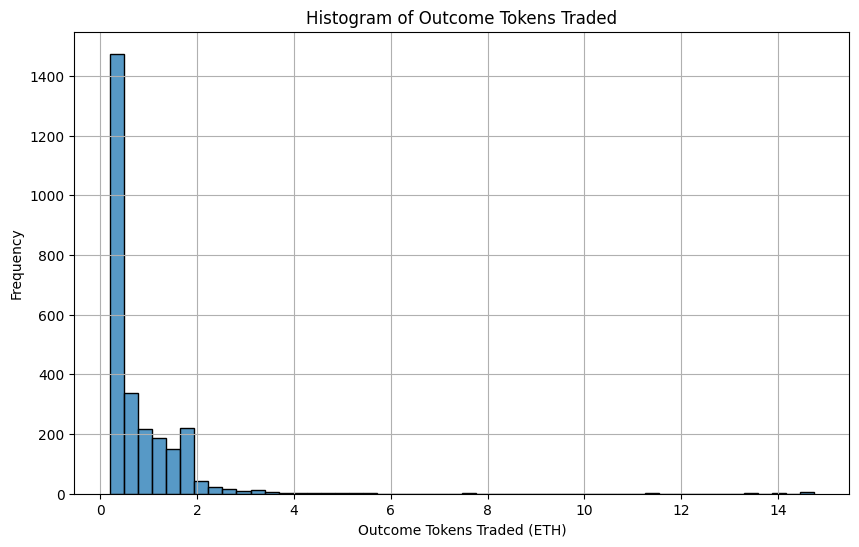

Market with max. outcomeTokensTraded 
0xe7192c9e0c013b1a355b780959c30c399a5c6ff30x3c01b79bad670a37c8784bdf47b973b341064f100x2e1
14.75095504900555


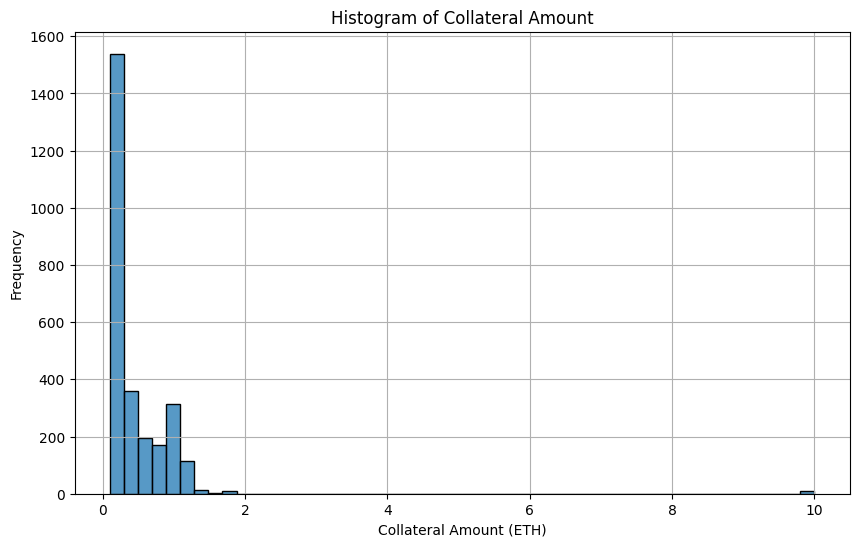

Market with max. collateralAmount 
0xce500294704e1243b5cb69a258196c0b1c65a7530x3c01b79bad670a37c8784bdf47b973b341064f100x29f
10.0


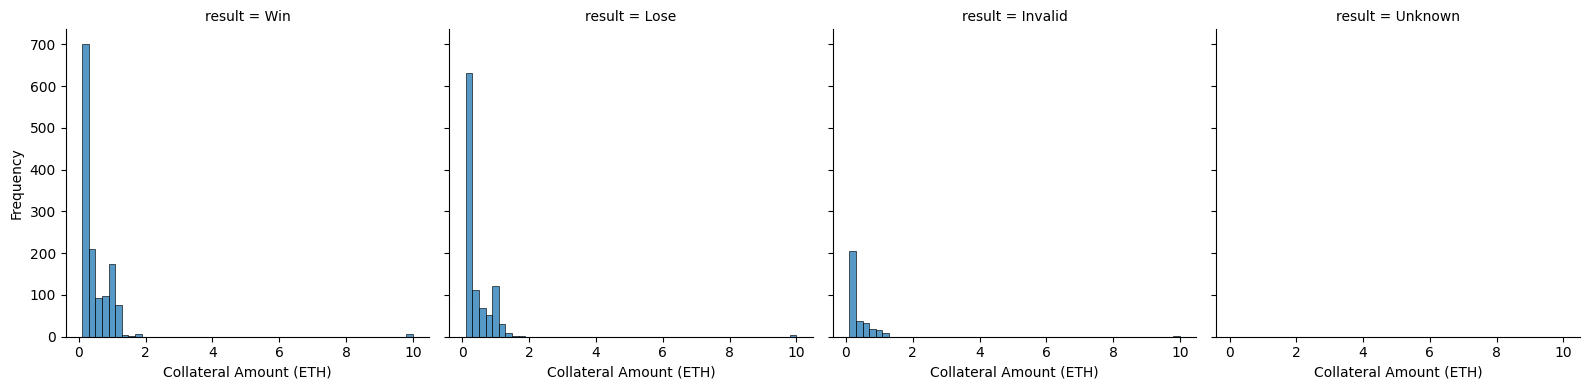

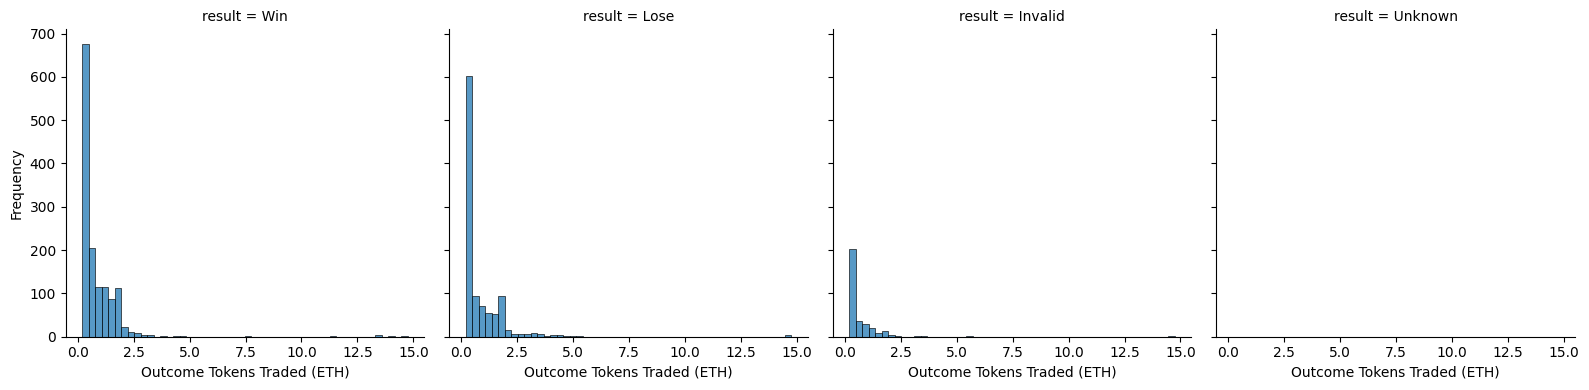

In [16]:
# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['outcomeTokensTraded'], bins=50)
plt.title('Histogram of Outcome Tokens Traded')
plt.xlabel('Outcome Tokens Traded (ETH)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
print("Market with max. outcomeTokensTraded ")
max_id = df.loc[df['outcomeTokensTraded'].idxmax(), 'id']
print(max_id)
print(df['outcomeTokensTraded'].max())

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['collateralAmount'], bins=50)
plt.title('Histogram of Collateral Amount')
plt.xlabel('Collateral Amount (ETH)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
print("Market with max. collateralAmount ")
max_id = df.loc[df['collateralAmount'].idxmax(), 'id']
print(max_id)
print(df['collateralAmount'].max())


# Create grid for histograms
g = sns.FacetGrid(df, col='result', col_wrap=4, height=4)
g.map(sns.histplot, 'collateralAmount', bins=50)
g.set_axis_labels('Collateral Amount (ETH)', 'Frequency')
plt.show()

# Create grid for histograms
g = sns.FacetGrid(df, col='result', col_wrap=4, height=4)
g.map(sns.histplot, 'outcomeTokensTraded', bins=50)
g.set_axis_labels('Outcome Tokens Traded (ETH)', 'Frequency')
plt.show()

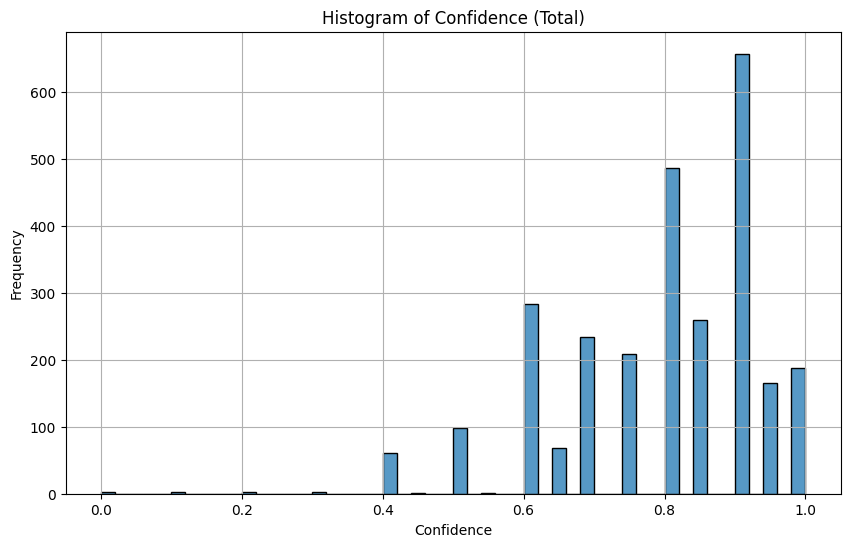

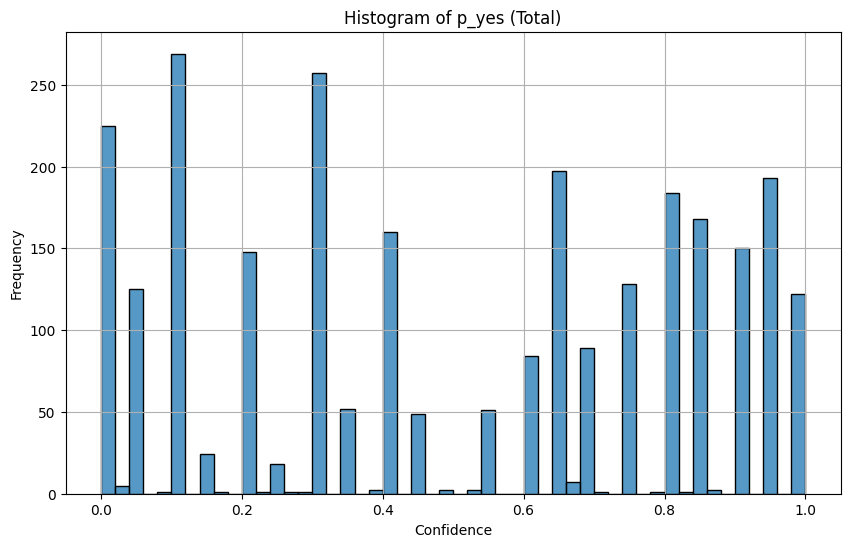

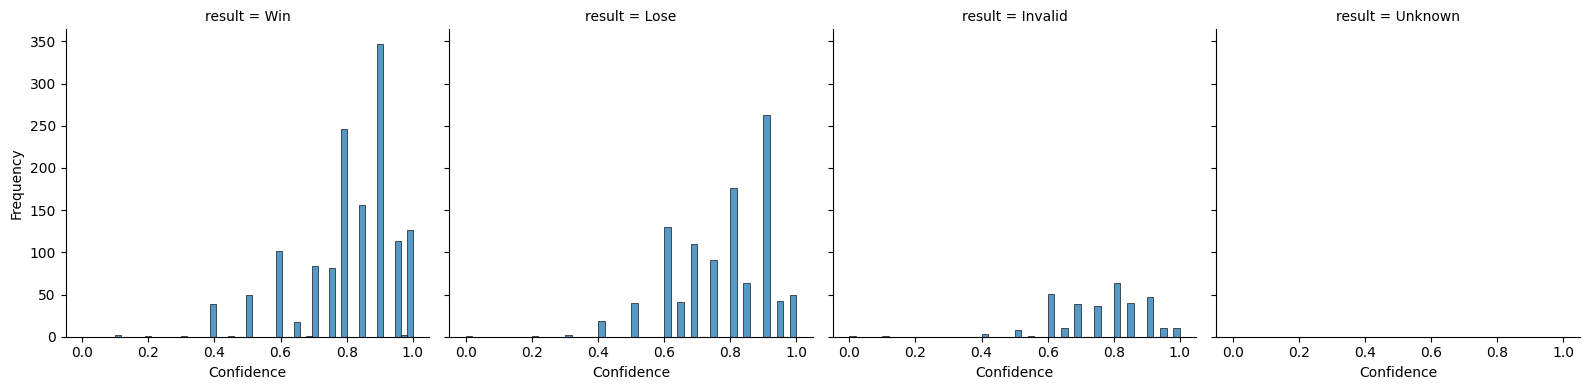

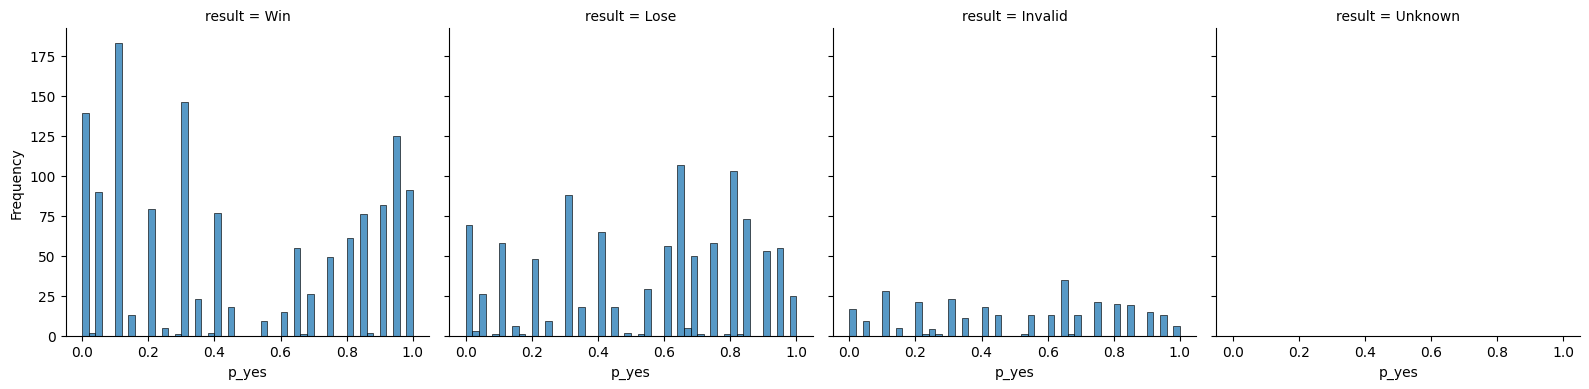

In [17]:

# Plot histogram of confidence (total)
plt.figure(figsize=(10, 6))
sns.histplot(df['deliver.confidence'], bins=50)
plt.title('Histogram of Confidence (Total)')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot histogram of p_yes (total)
plt.figure(figsize=(10, 6))
sns.histplot(df['deliver.p_yes'], bins=50)
plt.title('Histogram of p_yes (Total)')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Create grid for histograms of confidence per market state
g = sns.FacetGrid(df, col='result', col_wrap=4, height=4)
g.map(sns.histplot, 'deliver.confidence', bins=50)
g.set_axis_labels('Confidence', 'Frequency')
plt.show()

# Create grid for histograms of p_yes per market state
g = sns.FacetGrid(df, col='result', col_wrap=4, height=4)
g.map(sns.histplot, 'deliver.p_yes', bins=50)
g.set_axis_labels('p_yes', 'Frequency')
plt.show()

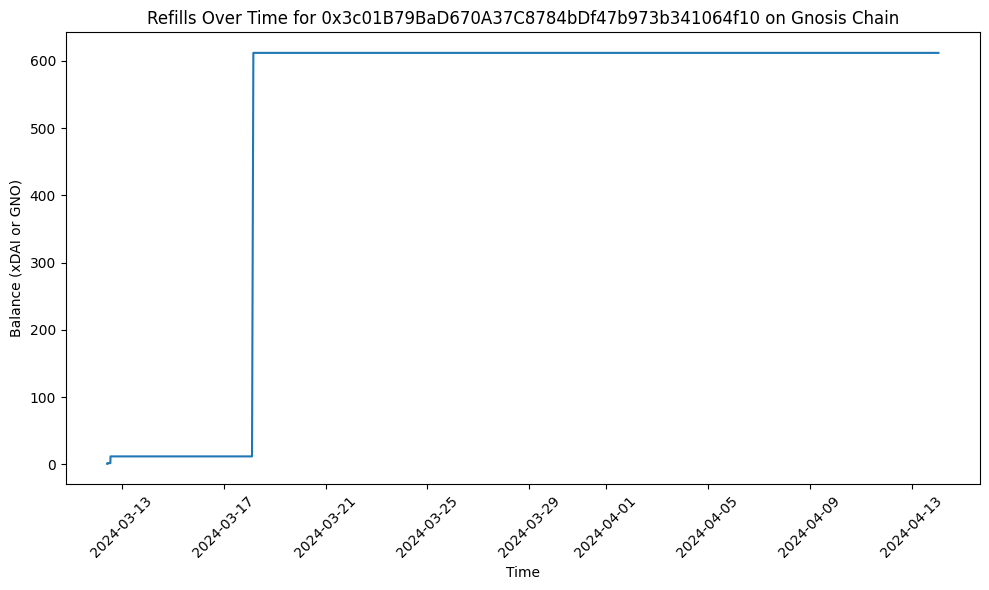

In [18]:


# GnosisScan URL to get transaction history
gnosisscan_api_key = env_file_vars.get("GNOSISSCAN_API_KEY")
url = f"https://api.gnosisscan.io/api?module=account&action=txlist&address={service_safe_address}&startblock=0&endblock=99999999&sort=asc&apikey={gnosisscan_api_key}"
response = requests.get(url)
data = response.json()

if data['status'] == '1':
    transactions = data['result']
else:
    print("Error fetching data:", data['message'])
    transactions = []

# Initialize lists to store balance over time
timestamps = []
balances = []

# Track the balance over time
balance = 0  # in wei
for tx in transactions:
    timestamp = datetime.utcfromtimestamp(int(tx['timeStamp']))
    timestamps.append(timestamp)

    value = int(tx['value'])  # value in wei
    if tx['to'].lower() == service_safe_address.lower():
        balance += value  # Incoming transaction
    elif tx['from'].lower() == service_safe_address.lower():
        balance -= value  # Outgoing transaction
    
    # Convert from wei to ether (or native token like xDAI) and store balance
    balances.append(balance / 10**18)

# Plot the balance over time
plt.figure(figsize=(10, 6))
plt.plot(timestamps, balances)
plt.title(f'Refills Over Time for {service_safe_address} on Gnosis Chain')
plt.xlabel('Time')
plt.ylabel('Balance (xDAI or GNO)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()